# car_evaluation 데이터셋

- 컬럼 구성
    - price : 자동차 가격
    - maint : 자동차 유지 비용
    - doors : 자동차 문 개수
    - presons : 수용 인원
    - lug_capacity : 수하물 용량
    - safety : 안정성
    - output(종속변수) : 차 상태
        - 아래의 범주중 하나의 값을 가짐
            - unacc : 허용 불가능한 수준
            - acc : 허용 가능한 수준
            - good : 양호
            - vgood : 매우 양호

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# 파이토치의 데이터셋과 시각화와 충돌이 잘 일어난다
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# 데이터 준비

In [8]:
dataset = pd.read_csv("./data/car_evaluation.csv", index_col = False)

In [9]:
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [10]:
dataset.shape

(1728, 7)

- 1728개의 데이터, 7개의 컬럼

In [11]:
dataset.dtypes

price           object
maint           object
doors           object
persons         object
lug_capacity    object
safety          object
output          object
dtype: object

- 으악 모두 object 타입이다!

- 종속변수 확인

In [13]:
dataset["output"].value_counts()

output
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

### os 안쓰면 터지는 코드다 근데 랜덤임
- kernel is dead 메모리 누수가 생겨버림

<Axes: ylabel='count'>

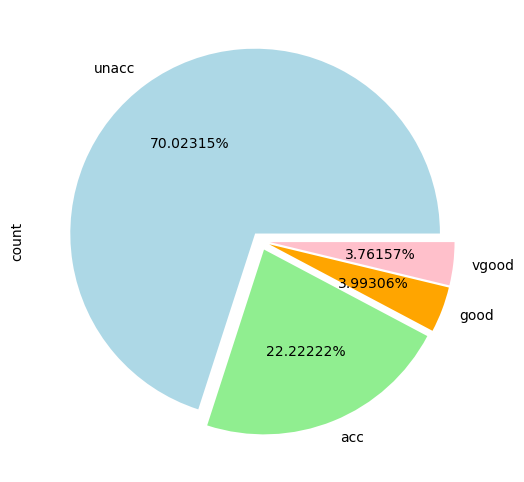

In [15]:
plt.figure(figsize = (8, 6))
dataset["output"].value_counts().plot(
    kind = "pie",
    autopct = "%0.05f%%",
    colors = ['lightblue', "lightgreen", "orange", "pink"],
    explode =(0.05,0.05,0.05,0.05)
)

- 분류가 아닌 회귀 모델을 만들어도 꽤나 괜찮은 부분~

### 데이터를 범주형 타입으로 변환

In [17]:
categorical_columns = ["price","maint", "doors","persons", "lug_capacity", "safety"]


# astype() 메서드를 이용하여 데이터를 범주형으로 변환
for category in categorical_columns:
    dataset[category] = dataset[category].astype("category")

In [18]:
dataset.dtypes

price           category
maint           category
doors           category
persons         category
lug_capacity    category
safety          category
output            object
dtype: object

In [20]:
dataset.head() # 나는 범주형이다! 라고 인식함

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


- 범주형 데이터를 텐서로 변환하기 위한 절차
    - 범주형 데이터 => astype("category") => 넘파이 배열 => 텐서

# 레이블인코딩하는법
- cat.codes 이용

In [24]:
price = dataset["price"].cat.codes.values
maint = dataset["maint"].cat.codes.values
doors = dataset["doors"].cat.codes.values
persons = dataset["persons"].cat.codes.values
lug_capacity = dataset["lug_capacity"].cat.codes.values
safety = dataset["safety"].cat.codes.values

In [27]:
# 열방향 연결임
categorical_data = np.stack([price,maint,doors,persons,lug_capacity,safety], 1)
categorical_data[:5]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2]], dtype=int8)

In [29]:
# 텐서로 타입 변경
categorical_data = torch.tensor(categorical_data, dtype = torch.int64)
categorical_data[:5]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2]])

In [30]:
# 정답값 변환
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [49]:
# 레이블로 사용할 컬럼을 텐서로 변환
outputs = pd.get_dummies(dataset["output"])

In [50]:
outputs.head()

,acc,good,unacc,vgood
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False


In [51]:
outputs = outputs.values
outputs

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       ...,
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False, False,  True]], shape=(1728, 4))

In [52]:
# true 인값의 위치를 tensor 로 변환하고 그걸 1차원 으로 평탄탄화
outputs = torch.tensor(outputs.argmax(axis = 1)).flatten()
outputs

tensor([2, 2, 2,  ..., 2, 1, 3])

# 독립/종속 변수 다시 확인

In [53]:
# 독립변수
categorical_data.shape

torch.Size([1728, 6])

In [54]:
# 종속변수
outputs.shape

torch.Size([1728])

- 딥러닝에서는 범주형 변수는 임베딩해주는 선택지가 있다

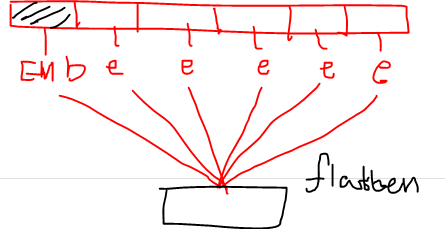

- 마징가 Z

### 각 범주 간의 세부적인 관계를 잘 파악하기 위해 임베딩
- 임베딩 크기는 각 컬럼의 고유값 수 나누기 2로 임의로 사용

In [64]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]

In [65]:
categorical_column_sizes

[4, 4, 4, 3, 3, 3]

In [66]:
# price 컬럼의 범주수
dataset["price"].cat.categories

Index(['high', 'low', 'med', 'vhigh'], dtype='object')

In [70]:
categorical_embedding_sizes = [(col_size, min(50, (col_size + 1) // 2 )) for col_size in categorical_column_sizes]

In [71]:
# (모든 범주형 컬럼의 고유값 수, 차원의 크기)
categorical_embedding_sizes

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]

## 데이터 분할

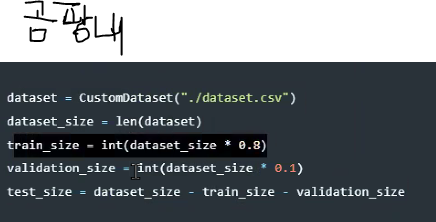

### 곰팡내 코드 두려워하지 말라~~~ (예방)

In [74]:
# 데이터셋 분리(8 : 2)
total_records = categorical_data.shape[0]
test_records = int(total_records * 0.2)

In [75]:
categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records : total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records: total_records]

In [76]:
print("x_train", len(categorical_train_data))
print("x_test", len(categorical_test_data))
print("y_train", len(train_outputs))
print("y_test", len(test_outputs))

x_train 1383
x_test 345
y_train 1383
y_test 345


### 모델 생성

In [79]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p = 0.5):
        '''
        모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도
        객체가 생성될 때 자동으로 호출됨

        embedding_size  : 범주형의 컬럼의 임베딩 크기
        output_size     : 출력층의 크기
        layers          : 모든 계층에 대한 목록
        p               : 드롭아웃(기본값은 0.5)
        '''
        super.__init__()

        # 임베딩 적용
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])

        # 드롭아웃 적용
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []

        # ni : number input, nf : number features
        num_categorical_cols = sum((nf for ni, nf in embedding_size)) # 컬럼의 개수 구하려고 nf 를 다 더하는 것임
        # input size는 12개
        input_size = num_categorical_cols

        # layers 유닛수를 받을것임
        for i in layers:
            # 전결합층
            all_layers.append(nn.Linear(input_size, i))
            
            # 활성화 함수
            all_layers.append(nn.ReLU(inplace = True))
            
            # 배치 정규화
            # 신경망 안에서 데이터의 평균과 분산을 조정
            all_layers.append(nn.BatchNorm1d(i))

            # 드롭아웃
            all_layers.append(nn.Dropout(p))
            input_size = i

        # layers[-1] 유닛수의 마지막 값 , output_size : 출력해야할 개수
        all_layers.append(nn.Linear(layers[-1], output_size)) # 밀집층


        # * 아스타를 붙혀주면 unpacking 하나~ 하나풀어서 인자 전달
        self.layers = nn.Sequential(*all_layers) 


        # 순전파 연결

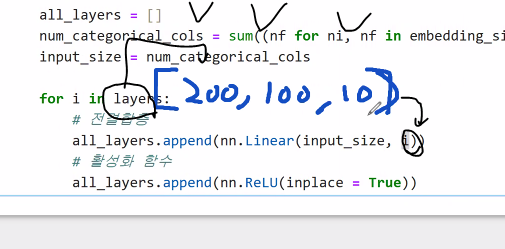